<a href="https://colab.research.google.com/github/aminar034/ml1000-p1/blob/working_models/Project1_wine_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wine Quality Classification
**Abstract**

Quality is the degree to which a product meets specified requirements. To assess white wine quality, it is essential to select measure(s) that directly impact its quality. In this study, we will be using physicochemical properties as features to evaluate the white wine’s quality attribute.

**Background**

Our client is the retailer and wholesaler, Liquor Control Board of Ontario (LCBO). They would like to assess white wine quality to determine its prices as part of their research quality management. Wine quality can be assessed either by physicochemical properties or by human sensory testing. Physicochemical properties include pH, dissolved salts, sodium levels, the acidity, and density. As the demand of high-quality wine is increasing, the need for better prediction of wine quality in an efficient and convenient way is also in high demand. Human sensory testing of wine quality can be a time-consuming process and open to interpretation. Another method in wine informatics is exploring machine learning techniques to classify various wine attributes such as quality based on wine quality evaluation.

**Objective** 
The objective of this study is to use binary classification model to determine which white wines are high quality or low quality based on several important physicochemical properties. We use the white wine quality dataset retrieved from the UCI Machine learning repository: https://archive.ics.uci.edu/ml/datasets/Wine+Quality.

**References**

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., and Reis, J.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

Mani, S., Krishnankutty, R. A., Swaminathan, S., & Theerthagiri, P. (2023). An investigation of wine quality testing using machine learning techniques. IAES International Journal of Artificial Intelligence, 12(2), 747.



## Install packages and load in dataset

* When using colab, need to install pycaret everytime
* Read in the wine quality dataset using the "raw" link from the git repository
  * alternatively can use any other url for the data that ends in .csv
  * trying to avoid linking the colab notebook to git, google drive or local server for reproducibility

In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd

df_path = 'https://raw.githubusercontent.com/DeepCodeSec/ml1000-p1/working_models/data/winequality-white.csv'  
dataset = pd.read_csv(df_path, 
                   sep=';') #the separater in the raw data is ;. need to indicate so columns are found
dataset.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [ ]:
# What is the distribution of the target variable (quality)
dataset.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


### Recode quality to a binary label
**Original**: quality of wine rated from 0-10 with 10 as the best

Above shows that the minimum rating was a 3 and max is 9. The mean and median are both ~6.

According to the website below, a rating of 7+ is good wine. https://vineroutes.com/wine-rating-system/#:~:text=Wines%20rated%2089%20and%20above,outstanding%20for%20its%20particular%20type. 

**New**: For the purpose of classification, we recode quality to a binary label: 1 = 'high quality' if the quality rating was 7 or above, and 0 = 'standard' where the quality rating was 6 or lower.

In [ ]:
import numpy as np

#add binary classification label
dataset['new_quality'] = np.where(dataset['quality'] > 6, 
                               1,
                               0)
dataset.head(100)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,new_quality
0,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,0
1,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,0
2,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,0
3,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
4,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,7.1,0.260,0.29,12.4,0.044,62.0,240.0,0.9969,3.04,0.42,9.2,6,0
96,6.0,0.340,0.66,15.9,0.046,26.0,164.0,0.9979,3.14,0.50,8.8,6,0
97,8.6,0.265,0.36,1.2,0.034,15.0,80.0,0.9913,2.95,0.36,11.4,7,1
98,9.8,0.360,0.46,10.5,0.038,4.0,83.0,0.9956,2.89,0.30,10.1,4,0


In [ ]:
#drop old quality column and rename new
dataset = dataset.drop(columns=['quality']) #drops old column
dataset = dataset.rename(columns={'new_quality':'quality'}) #renames back to quality

dataset.head() #double check it did what we asked

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,0
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,0
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,0


## Exploratory analysis report

The code below automatically creates an exploratory data analysis repor which is output as an html file in the local files. What follows are the highlights of this EDA report:

In [ ]:
#Load libraries for exploratory analysis
!pip3 install pandas_profiling --upgrade
import pandas_profiling
from pandas_profiling import ProfileReport
import pandas as pd

pr = ProfileReport(dataset)

pr.to_file(output_file="EDA.html")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Dataset has:
* 12 variables (11 numeric predictors and 1 categorical target/label)
* 4898 observations
* no missing values

Distributions:
* imbalanced label classes (~20% high quality and 80% standard)
  * again, this is not an issue, it just tells us that we need to think about undersampling and choose the appropriate performance metric
* most of the predictor variables are fairly normally distributed
* alcohol, volatile acidity, and residual sugar are not normally distributed, so we can consider transforming these columns (eg log transformation) if needed


Interactions:
* skipping, not super interesting for classification because pycaret is just going to run a dozen models anyway. We are more interested in the interactions for a regression type problem where, for example, the revenue from tv x radio adcertisements is predicted better than from tv ads or radio adds alone

Correlations:
* moderate correlation between density + residual sugar, density + alcohol, alcohol + chlorides
* for now leaving, but revisit for fine tuning if we are getting poor performance

Duplicate rows:
* therer are a number of duplicate rows. It is hard to say if these are genuinely duplicates and should be removed, or if they are coincidental duplicates (ie 2 wine samples happen to have the same measurements)


## Split dataset

* 5% test set (unseen until after model is finalized) 
* The remaining 95% will be split in the pycaret setup function

First we remove the 5% test set before any feature engineering to avoid data leakage. Test set is randomly shuffled.

After feature engineering, the remaining data will be split into training and validation sets that follow the same distribution of target labels (ie using stratified sampling).

We also need to take into consideration the sampling method because we have imbalanced classes
* under/over sample
* stratified sampling 
* etc

In [ ]:
# split data into 95% and 5%
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (4653, 12)
Unseen Data For Predictions: (245, 12)


In [ ]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.9,0.28,0.49,7.7,0.045,48.0,195.0,0.99540,3.04,0.55,11.0,0
1,5.0,0.24,0.19,5.0,0.043,17.0,101.0,0.99438,3.67,0.57,10.0,0
2,8.3,0.26,0.31,2.0,0.029,14.0,141.0,0.99077,2.95,0.77,12.2,0
3,7.7,0.25,0.30,7.8,0.038,67.0,196.0,0.99555,3.10,0.50,10.1,0
4,4.4,0.32,0.39,4.3,0.030,31.0,127.0,0.98904,3.46,0.36,12.8,1


In [ ]:
data_unseen.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
1,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,0
2,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,1
3,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.9917,3.12,0.53,11.3,0
4,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.9972,3.30,0.36,8.9,0


## Data cleaning decisions

* Do outlier analysis here. Since the dataset has lower number of observations, opt for solutions that retain as much data as possible (eg capping the data as opposed to removing rows)
* Make decisions about transformations etc here

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4653 non-null   float64
 1   volatile acidity      4653 non-null   float64
 2   citric acid           4653 non-null   float64
 3   residual sugar        4653 non-null   float64
 4   chlorides             4653 non-null   float64
 5   free sulfur dioxide   4653 non-null   float64
 6   total sulfur dioxide  4653 non-null   float64
 7   density               4653 non-null   float64
 8   pH                    4653 non-null   float64
 9   sulphates             4653 non-null   float64
 10  alcohol               4653 non-null   float64
 11  quality               4653 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 436.3 KB


* No categorical variables other than the target (class) variable, so no categorical encoding necessary
* Recall from EDA that alcohol, volatile acidity, and residual sugar were not normally distributed, so we can consider transforming these columns (done in experiment setup)
* We already know that the data does not contain missing values (from the source and from EDA), so no imutation or row removal necessary.
* Check for outliers and decide what to do with them. See below:

### Outlier analysis

Two options: 
* 1) When lots of observations in dataset and only a few rows with outlier values (for any column), just remove rows containing outliers.
* 2) When fewer observations and more rows containing outlier values, cap the values at the IQR (interquartile range)


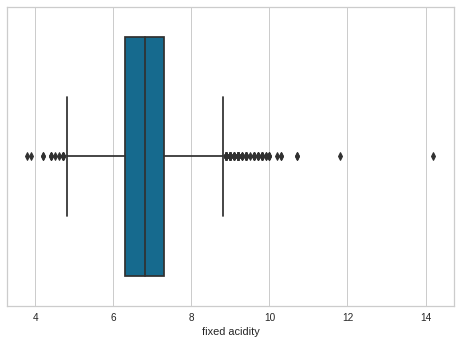

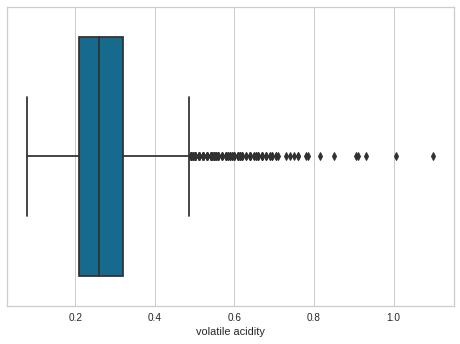

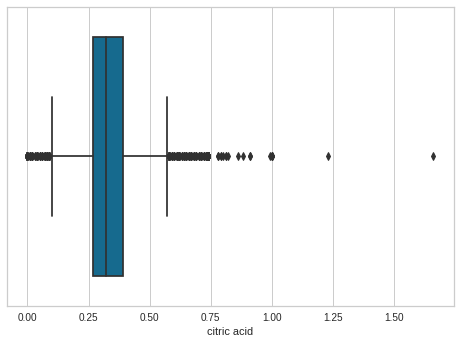

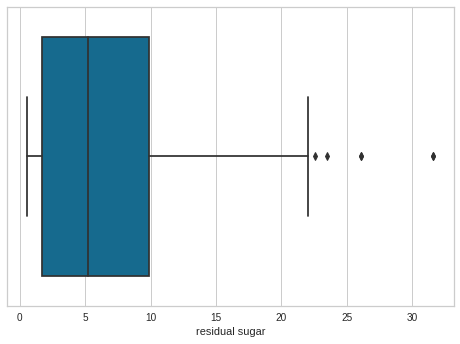

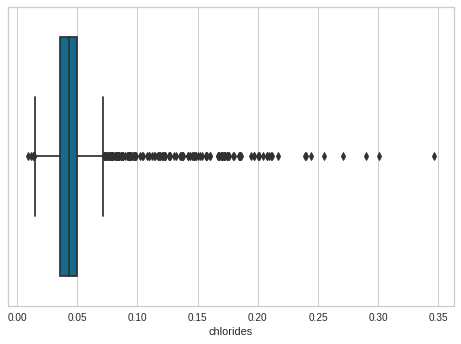

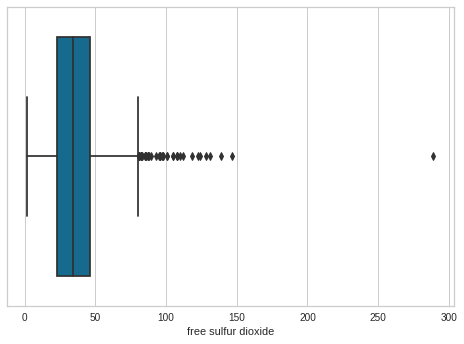

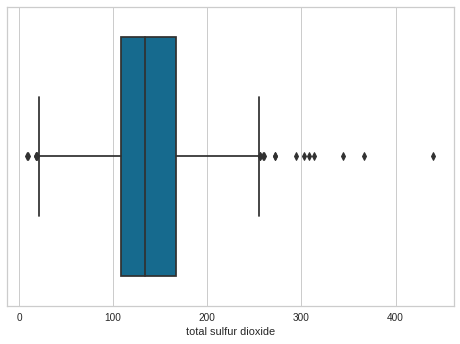

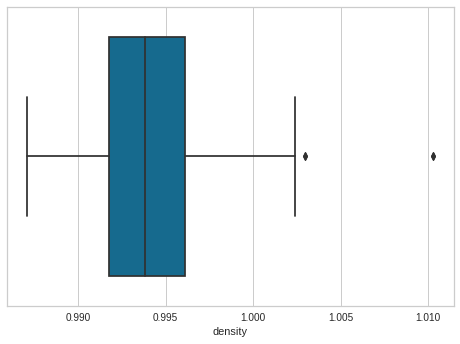

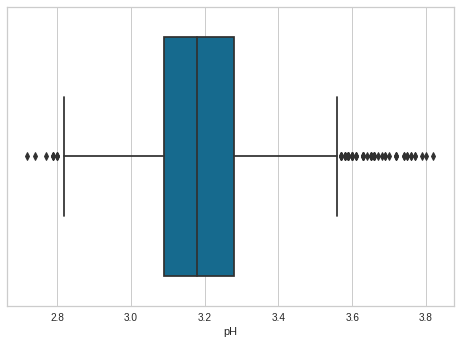

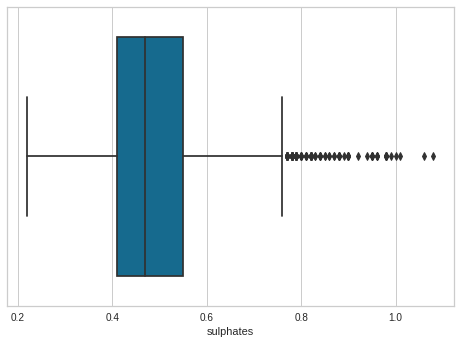

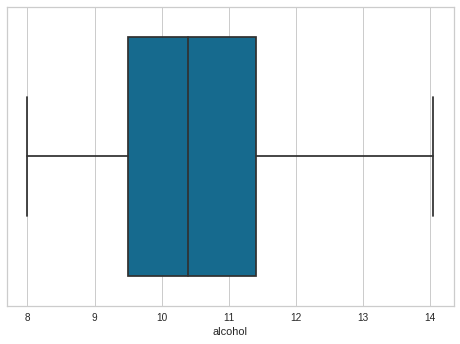

In [ ]:
# Outlier analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cols = list(data.columns)

#Create boxplot for every numeric feature (cols 0-11) to show outliers
for col in cols[0:-1]:
  plt.figure()
  sns.boxplot(data[col])
  plt.show()


The boxplots indicate that most of the predictors contain outlier values. Some of these predictors, like chlorides, contain a lot of outliers. Since there are so many outlier values, removing rows that contain outliers could leave us with a very small fraction of the original data. We opt to cap the values at the 5th and 95th percentiles to retain as much data as possible.

#### Capping outliers

Opting to cap outliers at the 5th (lower boundary) and 95th (upper boundary) percentiles. Each column is treated separately, so it doesn't matter that the features are on different scales at this point.

In [ ]:
tmp = data #creating a temporary to avoid accidentally overwriting the original (let's us compare and verify capping)
data_clean = data

In [ ]:
data.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,6.854406,0.277909,0.334030,6.405029,0.045796,35.343327,138.489792,0.994038,3.187746,0.489695,10.504821,0.215345
std,0.844952,0.100298,0.121024,5.008390,0.021997,17.025677,42.445410,0.002917,0.149787,0.113718,1.227265,0.411106
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991750,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993800,3.180000,0.470000,10.400000,0.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996120,3.280000,0.550000,11.400000,0.000000
max,14.200000,1.100000,1.660000,31.600000,0.346000,289.000000,440.000000,1.010300,3.820000,1.080000,14.050000,1.000000


In [ ]:
cols = list(data.columns)

#Create boxplot for every numeric feature (cols 0-11) to show outliers
for col in cols[0:-1]:
  upper_limit = tmp[col].mean() + 3*tmp[col].std() #~95th percentile
  lower_limit = tmp[col].mean() - 3*tmp[col].std() #~5th percentile
  
  data_clean[col] = np.where(tmp[col]> upper_limit, upper_limit, #if above 95th, set to upper
                        np.where(tmp[col]< lower_limit, lower_limit, #if below 5th, set to lower
                        tmp[col]))


In [ ]:
#Capped distributions. Verify by checking max and min
data_clean.describe() 

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,6.849577,0.275908,0.332161,6.397574,0.043971,35.156199,138.376386,0.994035,3.187265,0.488733,10.504821,0.215345
std,0.823442,0.092507,0.113452,4.980448,0.012600,16.063421,41.960838,0.002903,0.148137,0.110286,1.227265,0.411106
min,4.378806,0.080000,0.000000,0.600000,0.009000,2.000000,12.493214,0.987110,2.742837,0.220000,8.000000,0.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991750,3.090000,0.410000,9.500000,0.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993800,3.180000,0.470000,10.400000,0.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996120,3.280000,0.550000,11.400000,0.000000
max,9.320441,0.554230,0.673250,21.338944,0.083806,83.361560,264.259665,1.002743,3.631697,0.819693,14.050000,1.000000


## Training classifier models

Now that the data is clean, we can set up the classifier experiment pipeline.

In [ ]:
from pycaret.classification import *

## can someone clean up the wording?
EDA showed that serveral predictors were not normally distributed. The features were also on vastly different scales. For example, chlorides ranges from 0.009 - 0.346 while residual sugar ranges from 0.6 - 65.8. This impacts performance on certain classifier algorithms, so we will z-score normalize the features to put them all on the same scale (-3 to +3). This can be specified in the experiment setup. 

* second, we'll log transform the non-normally distributed predictors. There is a transfortamtion argument in the setup function.
* third, the numeric variables are on quite different scales.  There is a normalize argument in the setup function that we can use.
* fourth, we 'll use the remove_multicollinearity argument when we set up the pycaret experiment to deal with the correlated variables
* call back to imbalanced classes and why we opt to use SMOMTE

In [ ]:
exp_P1clf = setup(data = data_clean, #make sure to use cleaned data (outliers capped)
                   target = 'quality', data_split_stratify = True, session_id = 123,
                   transformation=True, #applies the power transform to make data more Gaussian-like
                   normalize=True, #transforms the numeric features by scaling them to a given range (default is z-score)
                   remove_multicollinearity=True, #features with the inter-correlations higher than the defined threshold are removed. When two features are highly correlated with each other, the feature that is less correlated with the target variable is removed
                   multicollinearity_threshold = 0.7, #by default was 0.9
                   fix_imbalance=True #default method is SMOTE
                )

,Description,Value
0,session_id,123
1,Target,quality
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(4653, 12)"
5,Missing Values,False
6,Numeric Features,11
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


INFO:logs:create_model_container: 0
INFO:logs:master_model_container: 0
INFO:logs:display_container: 1
INFO:logs:Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                                      numerical_features=[], target='quality',
                                      time_features=[])),
                ('imputer',
                 Simple_Imputer(categorical_strategy='not_available',
                                fill_value_categorical=None,
                                fill_value_numerical=None,
                                numeric_stra...
                ('dummy', Dummify(target='quality')),
                ('fix_perfect', Remove_100(target='quality')),
                ('clean_names', Clean_Colum_Names()),
   

In [ ]:
#Find best model
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.8618,0.9110,0.6990,0.6731,0.6829,0.5949,0.5972,0.463
rf,Random Forest Classifier,0.8493,0.8993,0.6975,0.6375,0.6642,0.5675,0.5699,1.175
lightgbm,Light Gradient Boosting Machine,0.8394,0.8786,0.6177,0.6314,0.6226,0.5209,0.5222,0.243
dt,Decision Tree Classifier,0.8004,0.7466,0.6520,0.5297,0.5836,0.4544,0.4593,0.097
dummy,Dummy Classifier,0.7848,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.027
gbc,Gradient Boosting Classifier,0.7835,0.8475,0.7219,0.4983,0.5890,0.4489,0.4636,1.213
ada,Ada Boost Classifier,0.7562,0.8135,0.7162,0.4589,0.5589,0.4018,0.4210,0.258
knn,K Neighbors Classifier,0.7498,0.8262,0.7561,0.4521,0.5649,0.4048,0.4322,0.073
lr,Logistic Regression,0.7099,0.7818,0.7819,0.4088,0.5368,0.3544,0.3943,0.317
ridge,Ridge Classifier,0.7046,0.0000,0.7947,0.4051,0.5365,0.3517,0.3951,0.042


INFO:logs:create_model_container: 14
INFO:logs:master_model_container: 14
INFO:logs:display_container: 2
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
INFO:logs:compare_models() succesfully completed......................................


The top 3 classifiers, extra trees, random forest, and light gradient boosting all have similar accuracy, auc and F1 scores. Let's tune all three and see which of the tuned models performs best on the validation set.

**Note:**
Since we have imbalanced classes, accuracy is not our most important performance metric. We will rely on the confusion matrix and precision (ability to identify true positives) to tune and choose our model.

In [ ]:
# train a extra tree model
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8466,0.9086,0.5714,0.6667,0.6154,0.5203,0.5227
1,0.8650,0.9169,0.7571,0.6625,0.7067,0.6195,0.6219
2,0.8620,0.8993,0.6571,0.6866,0.6715,0.5842,0.5844
3,0.8620,0.9085,0.6286,0.6984,0.6617,0.5753,0.5765
4,0.8804,0.9313,0.7714,0.7013,0.7347,0.6577,0.6589
5,0.8497,0.8700,0.5714,0.6780,0.6202,0.5273,0.5303
6,0.8558,0.9076,0.7324,0.6500,0.6887,0.5954,0.5972
7,0.8954,0.9568,0.8714,0.7093,0.7821,0.7142,0.7207
8,0.8646,0.9213,0.7143,0.6757,0.6944,0.6076,0.6080


INFO:logs:create_model_container: 15
INFO:logs:master_model_container: 15
INFO:logs:display_container: 3
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
# train a random forest model
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8405,0.8884,0.6857,0.6154,0.6486,0.5459,0.5472
1,0.8374,0.8989,0.7286,0.6000,0.6581,0.5527,0.5572
2,0.8405,0.8996,0.6143,0.6324,0.6232,0.5220,0.5221
3,0.8528,0.8967,0.6286,0.6667,0.6471,0.5541,0.5545
4,0.8528,0.9151,0.7429,0.6341,0.6842,0.5890,0.5921
5,0.8344,0.8573,0.5571,0.6290,0.5909,0.4875,0.4890
6,0.8558,0.9143,0.7465,0.6463,0.6928,0.5993,0.6019
7,0.8862,0.9471,0.8143,0.7037,0.7550,0.6813,0.6844
8,0.8523,0.9005,0.7000,0.6447,0.6712,0.5762,0.5770


INFO:logs:create_model_container: 16
INFO:logs:master_model_container: 16
INFO:logs:display_container: 4
INFO:logs:RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)
INFO:logs:create_model() succesfully completed......................................


In [ ]:
# train a lgb model
lgb = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8313,0.8808,0.6000,0.6087,0.6043,0.4971,0.4971
1,0.8405,0.8876,0.6143,0.6324,0.6232,0.5220,0.5221
2,0.8282,0.8688,0.5571,0.6094,0.5821,0.4743,0.4750
3,0.8497,0.8727,0.5429,0.6909,0.6080,0.5167,0.5224
4,0.8221,0.8928,0.6571,0.5750,0.6133,0.4985,0.5003
5,0.8344,0.8431,0.5571,0.6290,0.5909,0.4875,0.4890
6,0.8497,0.8886,0.6197,0.6667,0.6423,0.5474,0.5479
7,0.8862,0.9338,0.8000,0.7089,0.7517,0.6782,0.6803
8,0.8554,0.8758,0.6571,0.6667,0.6619,0.5699,0.5699


INFO:logs:create_model_container: 18
INFO:logs:master_model_container: 18
INFO:logs:display_container: 6
INFO:logs:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=123, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
INFO:logs:create_model() succesfully completed......................................


## Tuning the models (can someone rephrase the end to link it back to the business problem?)

Use the tune_model function to find the optimal hyperparameters for the model. Performance metric will be precision because we are most interested in the model's ability to identify true positives. That is, the LCBO wants to accurately price the high quality wines 


In [ ]:
# tune extra tree model
tuned_et = tune_model(et, optimize='Prec.')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7577,0.8511,0.8143,0.4634,0.5907,0.4364,0.4714
1,0.7546,0.8648,0.8714,0.4621,0.6040,0.4495,0.4970
2,0.7607,0.8509,0.7429,0.4643,0.5714,0.4175,0.4397
3,0.7546,0.8430,0.7857,0.4583,0.5789,0.4222,0.4528
4,0.7699,0.8337,0.7571,0.4775,0.5856,0.4375,0.4598
5,0.7270,0.8137,0.6714,0.4159,0.5137,0.3382,0.3569
6,0.7086,0.7877,0.6901,0.4016,0.5078,0.3207,0.3445
7,0.8092,0.8863,0.9143,0.5333,0.6737,0.5517,0.5917
8,0.7323,0.8411,0.7000,0.4261,0.5297,0.3578,0.3793


INFO:logs:create_model_container: 19
INFO:logs:master_model_container: 19
INFO:logs:display_container: 7
INFO:logs:ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


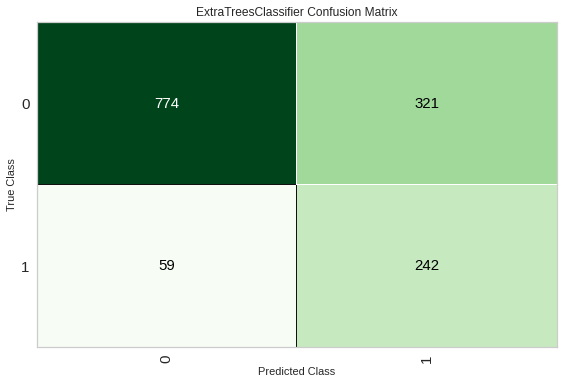

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_et, plot = 'confusion_matrix')

## comment on performance and relate back to business problem
Tuned model has %45 precision and 75% accuracy. Confusion matrix shows higher rate of fase positives than true positives. Potentially harmful to the client if they are marketing quality wines that are not, especially if they are sold at a higher price bracket.

In [ ]:
# tune random forest model
tuned_rf = tune_model(rf, optimize='Prec.')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7607,0.8488,0.8000,0.4667,0.5895,0.4367,0.4683
1,0.7423,0.8577,0.7714,0.4426,0.5625,0.3983,0.4292
2,0.7883,0.8522,0.7286,0.5050,0.5965,0.4594,0.4735
3,0.8006,0.8294,0.7286,0.5258,0.6108,0.4814,0.4930
4,0.7914,0.8459,0.7571,0.5096,0.6092,0.4742,0.4915
5,0.7270,0.7986,0.6143,0.4095,0.4914,0.3149,0.3270
6,0.7117,0.8130,0.6761,0.4034,0.5053,0.3197,0.3409
7,0.8185,0.8957,0.8857,0.5487,0.6776,0.5608,0.5919
8,0.7692,0.8389,0.6429,0.4737,0.5455,0.3955,0.4038


INFO:logs:create_model_container: 20
INFO:logs:master_model_container: 20
INFO:logs:display_container: 8
INFO:logs:RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False)
INFO:logs:tune_model() succesfully completed......................................


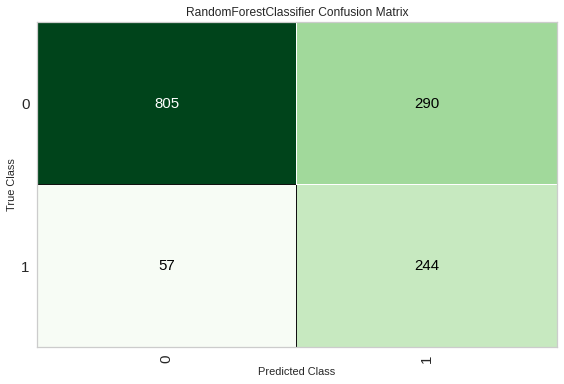

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_rf, plot = 'confusion_matrix')

## repeat what was done for et classifier

Make comments about precision, accuracy, (found in tuned model, go to the mean performance) and confusion matrix. Compare to et

In [ ]:
# tune lgb model
tuned_lgb = tune_model(lgb, optimize='Prec.')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8436,0.8950,0.5857,0.6508,0.6165,0.5186,0.5198
1,0.8497,0.8511,0.6286,0.6567,0.6423,0.5472,0.5475
2,0.8466,0.8560,0.5857,0.6613,0.6212,0.5255,0.5270
3,0.8497,0.8589,0.5857,0.6721,0.6260,0.5325,0.5344
4,0.8650,0.8932,0.7429,0.6667,0.7027,0.6157,0.6172
5,0.8313,0.8319,0.5286,0.6271,0.5736,0.4694,0.4721
6,0.8650,0.8614,0.6620,0.7015,0.6812,0.5956,0.5961
7,0.8615,0.9282,0.8000,0.6437,0.7134,0.6235,0.6299
8,0.8462,0.8969,0.6143,0.6515,0.6324,0.5352,0.5356


INFO:logs:create_model_container: 21
INFO:logs:master_model_container: 21
INFO:logs:display_container: 9
INFO:logs:LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
INFO:logs:tune_model() succesfully completed......................................


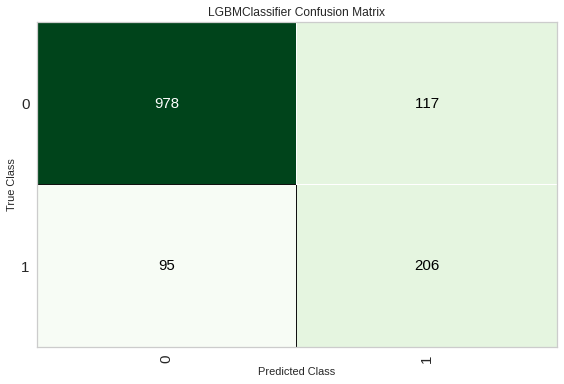

INFO:logs:Visual Rendered Successfully
INFO:logs:plot_model() succesfully completed......................................


In [ ]:
plot_model(tuned_lgb, plot = 'confusion_matrix')

## repeat what was done for et and rf classifier

Make comments about precision, accuracy, (found in tuned model, go to the mean performance) and confusion matrix. Compare to et

## Check performance on validation sets

The tuned models above tell us how the model performs on the training data, but we want to know how well our classifier performs on unseen data before we determine which is best because accuracy is always higher on training data than test data.

In [ ]:
#ET performance on the validation set
pred_holdout_et = predict_model(tuned_et)
pred_holdout_et.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0,
                     class_weight='balanced_subsample', criterion='gini',
                     max_depth=6, max_features=1.0, max_leaf_nodes=None,
                     max_samples=None, min_impurity_decrease=0,
                     min_impurity_split=None, min_samples_leaf=4,
                     min_samples_split=7, min_weight_fraction_leaf=0.0,
                     n_estimators=200, n_jobs=-1, oob_score=False,
                     random_state=123, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7278,0.8375,0.804,0.4298,0.5602,0.3883,0.4282


,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality,Label,Score
0,-0.236945,-0.148537,0.257667,-0.784333,0.283892,-0.370703,0.099835,-0.821698,1.652311,0,1,0.8592
1,-1.328910,-1.023989,-0.695223,0.013572,-0.024714,-0.296549,0.298438,-0.701081,-1.137028,0,0,0.7546
2,-0.632079,-0.419966,1.337734,0.600194,1.743240,1.603736,0.363247,-1.599922,-0.803320,0,0,0.8483
3,0.598951,1.135776,-0.905309,0.600194,-1.096339,-0.852266,-0.536955,0.662836,0.691685,0,0,0.5832
4,0.818899,0.215861,0.082074,0.471080,0.513223,0.978935,1.217709,0.957118,-0.194076,0,0,0.7107


In [ ]:
#RF performance on the validation set
pred_holdout_rf = predict_model(tuned_rf)
pred_holdout_rf.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=RandomForestClassifier(bootstrap=False, ccp_alpha=0.0,
                       class_weight='balanced_subsample', criterion='gini',
                       max_depth=6, max_features='log2', max_leaf_nodes=None,
                       max_samples=None, min_impurity_decrease=0.001,
                       min_impurity_split=None, min_samples_leaf=6,
                       min_samples_split=9, min_weight_fraction_leaf=0.0,
                       n_estimators=190, n_jobs=-1, oob_score=False,
                       random_state=123, verbose=0, warm_start=False), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7514,0.8463,0.8106,0.4569,0.5844,0.4262,0.4618


,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality,Label,Score
0,-0.236945,-0.148537,0.257667,-0.784333,0.283892,-0.370703,0.099835,-0.821698,1.652311,0,1,0.8370
1,-1.328910,-1.023989,-0.695223,0.013572,-0.024714,-0.296549,0.298438,-0.701081,-1.137028,0,0,0.8497
2,-0.632079,-0.419966,1.337734,0.600194,1.743240,1.603736,0.363247,-1.599922,-0.803320,0,0,0.9001
3,0.598951,1.135776,-0.905309,0.600194,-1.096339,-0.852266,-0.536955,0.662836,0.691685,0,0,0.7342
4,0.818899,0.215861,0.082074,0.471080,0.513223,0.978935,1.217709,0.957118,-0.194076,0,0,0.7873


In [ ]:
#LGB performance on the validation set
pred_holdout_lgb = predict_model(tuned_lgb)
pred_holdout_lgb.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8481,0.8873,0.6844,0.6378,0.6603,0.5626,0.5632


,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,quality,Label,Score
0,-0.236945,-0.148537,0.257667,-0.784333,0.283892,-0.370703,0.099835,-0.821698,1.652311,0,1,0.9891
1,-1.328910,-1.023989,-0.695223,0.013572,-0.024714,-0.296549,0.298438,-0.701081,-1.137028,0,0,0.9937
2,-0.632079,-0.419966,1.337734,0.600194,1.743240,1.603736,0.363247,-1.599922,-0.803320,0,0,0.9987
3,0.598951,1.135776,-0.905309,0.600194,-1.096339,-0.852266,-0.536955,0.662836,0.691685,0,0,0.9486
4,0.818899,0.215861,0.082074,0.471080,0.513223,0.978935,1.217709,0.957118,-0.194076,0,0,0.9569


## Finalizing the model (someone clean this up please)

We choose the light gradient boosting model because it has the highest precision, accuracy, and auc on test/validation data compared to rf and et.

In [ ]:
#Finalize model and retrain on the combined training and validation sets before testing on the 5% holdout
final_lgb = finalize_model(tuned_lgb)

INFO:logs:Initializing finalize_model()
INFO:logs:finalize_model(estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), fit_kwargs=None, groups=None, model_only=True, display=None, experiment_custom_tags=None, return_train_score=False)
INFO:logs:Finalizing LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
       

In [ ]:
print(final_lgb)

LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)


## Predict on unseen data (5% holdout)

In [ ]:
# 5% sample witheld in the beginning
data_unseen.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0
1,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,0
2,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,1
3,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.9917,3.12,0.53,11.3,0
4,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.9972,3.30,0.36,8.9,0


In [ ]:
# drop the quality column (classification label) from data_unseen
data_unseen.drop('quality', axis = 1, inplace = True)
data_unseen.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1
1,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7
2,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4
3,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.9917,3.12,0.53,11.3
4,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.9972,3.30,0.36,8.9


In [ ]:
#predict class using the finalized model
pred_unseen = predict_model(final_lgb, data=data_unseen)
pred_unseen.head()

INFO:logs:Initializing predict_model()
INFO:logs:predict_model(estimator=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), probability_threshold=None, encoded_labels=False, drift_report=False, raw_score=False, round=4, verbose=True, ml_usecase=MLUsecase.CLASSIFICATION, display=None, drift_kwargs=None)
INFO:logs:Checking exceptions
INFO:logs:Preloading libraries
INFO:logs:Preparing display monitor


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,Label,Score
0,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,0,0.9946
1,8.6,0.23,0.40,4.2,0.035,17.0,109.0,0.9947,3.14,0.53,9.7,0,0.9884
2,6.6,0.16,0.40,1.5,0.044,48.0,143.0,0.9912,3.54,0.52,12.4,1,0.8064
3,7.4,0.34,0.42,1.1,0.033,17.0,171.0,0.9917,3.12,0.53,11.3,0,0.6941
4,6.0,0.19,0.26,12.4,0.048,50.0,147.0,0.9972,3.30,0.36,8.9,0,0.9858


In [ ]:
#save model
save_model(final_lgb,'lgb_final_pipeline')

INFO:logs:Initializing save_model()
INFO:logs:save_model(model=LGBMClassifier(bagging_fraction=0.9, bagging_freq=3, boosting_type='gbdt',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.5,
               importance_type='split', learning_rate=0.4, max_depth=-1,
               min_child_samples=6, min_child_weight=0.001, min_split_gain=0.3,
               n_estimators=20, n_jobs=-1, num_leaves=150, objective=None,
               random_state=123, reg_alpha=0.005, reg_lambda=0.0005,
               silent='warn', subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0), model_name=lgb_final_pipeline, prep_pipe_=Pipeline(memory=None,
         steps=[('dtypes',
                 DataTypes_Auto_infer(categorical_features=[],
                                      display_types=True, features_todrop=[],
                                      id_columns=[],
                                      ml_usecase='classification',
                              

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True, features_todrop=[],
                                       id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='quality',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_stra...
                                 colsample_bytree=1.0, feature_fraction=0.5,
                                 importance_type='split', learning_rate=0.4,
                                 max_depth=-1, min_child_samples=6,
                                 min_child_weight=0.

## Conclusions
* which model we chose and why
* how it addresses the business problem
* link to heroku app

## References